# Investigating "no-shows" in medical appointments in Brazil

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

A big deal of patients do not attend their medical appointments in Brazil. To find out why so many people miss their appointment, Joni Hoppen and Aquarela Advanced Analytics have provied a dataset with more than 100,000 entries and 14 varialbes. The dataset is free to download from kaggle just follow this [link](https://www.kaggle.com/joniarroba/noshowappointments)

In this report we will be analyzing the above mentioned dataset and finding insights in why people do not attend their medical appointments. We will be working along the following two questions:

* **Question 1:** Does the time between scheduling the appointment and the appointment itself have an impact in the no-show behaviour of the patients?
* **Question 2:** Are males more likely to miss an appointment? How does the age affect each gender in their behaviour of showing up (or not showing up) to the medical appointments? 

Let us first do the setup and get all the libraries we will be working with

In [1]:
# import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # just in case we want to make fancy graphics 

%matplotlib inline 

<a id='wrangling'></a>
## Data Wrangling

In this section of the report, we will load the data and check for "cleanliness", and then trim and clean the dataset for our analysis. By the end of this section we will be ready to start the exploratory part!

In [2]:
# load the data - since I saved the data in the same directory, there is no need to change it
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

# make sure the data was loaded properly
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Great! the data seems to be working fine, now let us understand it better

In [3]:
df.shape

(110527, 14)

To make my life easier, I will change all labels to lower case and delete all possible blank spaces:

In [4]:
# first chage all the labels to lowercase and make sure there are no weird spaces. Furthermore lets make all underscored

df.rename(columns = lambda x: x.strip().lower().replace('-','_'), inplace=True)

# check if the changes worked

df.head(1)

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No


In [5]:
df.describe()

,patientid,appointmentid,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


The first statistics about the data give us the first insights:
* The min and the max of the variable Age seem a little bit odd
* Handcap is a true or false statement, so there should not be a max value of "4"
* the "No-show" variable is no numerical value. This column is bit tricky since "Yes" means the patient didn't show to the appointment

In [6]:
# check the age variables to see how many pacients are above 90

df.query('age >= 90')['age'].value_counts(sort=False, ascending=True)

90     109
91      66
92      86
93      53
94      33
95      24
96      17
97      11
98       6
99       1
100      4
102      2
115      5
Name: age, dtype: int64

Patients with the age of 115 are very suspicious, and because they are not representative in the dataset I will just drop all their entries

In [7]:
df.drop(df.index[df.age == 115], inplace=True)
df.shape

(110522, 14)

Lets check the handcap column, to see where this "4" value is comming from

In [8]:
df.handcap.value_counts()

0    108285
1      2038
2       183
3        13
4         3
Name: handcap, dtype: int64

since there is only the possibility to be true or false, I will change all values above "1" to "1", meaning true

In [9]:
# replace all the values above one to the value one (true)

df.handcap.replace([2,3,4], 1, inplace=True)

# check that this worked out

df.handcap.value_counts()

0    108285
1      2237
Name: handcap, dtype: int64

Finally change the "no_show" column to numerical values so I can run some calculations on it

In [10]:
# lets take a look of the distribution first

df.no_show.value_counts()

No     88206
Yes    22316
Name: no_show, dtype: int64

In [11]:
# now lets change all "Yes" to "1" meaning True and all "No" to "0" meaning False

df.no_show.replace({"Yes": 1, "No": 0}, inplace=True)

# check this worked out
df.no_show.value_counts()

0    88206
1    22316
Name: no_show, dtype: int64

Awesome! lets see what else we need to change

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110522 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   patientid       110522 non-null  float64
 1   appointmentid   110522 non-null  int64  
 2   gender          110522 non-null  object 
 3   scheduledday    110522 non-null  object 
 4   appointmentday  110522 non-null  object 
 5   age             110522 non-null  int64  
 6   neighbourhood   110522 non-null  object 
 7   scholarship     110522 non-null  int64  
 8   hipertension    110522 non-null  int64  
 9   diabetes        110522 non-null  int64  
 10  alcoholism      110522 non-null  int64  
 11  handcap         110522 non-null  int64  
 12  sms_received    110522 non-null  int64  
 13  no_show         110522 non-null  int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 12.6+ MB


Some of the columns (variables) are irrelevant for our analysis, so I will drop the patient and appointment ID. Furthermore, since I cannot do much with the neighbourhood, because I do not know if it reflects some kind of socio-economic status, I will drop this column as well

In [13]:
df.drop(columns=['patientid', 'appointmentid', 'neighbourhood'], inplace=True)

Finally I want to change the "gender" variable to a numerical value to see the correlation to the no_show. To make it also easier to understand, I will rename the column to "female" with a binary value: 1 for true and 0 for false

In [14]:
# Check the distribution

df.gender.value_counts()

F    71835
M    38687
Name: gender, dtype: int64

In [15]:
# change the name of the variable

df.rename(columns = {'gender': 'female'}, inplace=True)
df.head(1)

,female,scheduledday,appointmentday,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show
0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,0,1,0,0,0,0,0


In [16]:
# change all "F" for 1 and all "M" to 0

df.female.replace({"F": 1, "M": 0}, inplace=True)

# check that all works

df.female.value_counts()

1    71835
0    38687
Name: female, dtype: int64

Furhtermore we will need to change the data type of "scheduledday" and "appointmentday" to dates. So that we can work easier with the values 

In [17]:
# now lets change the data type of the two variables

df.scheduledday = pd.to_datetime(df.scheduledday)
df.appointmentday = pd.to_datetime(df.appointmentday)

# check if this worked

print(df.scheduledday.dtypes)
print(df.appointmentday.dtypes)

datetime64[ns, UTC]
datetime64[ns, UTC]


Finally let's look for duplicates

In [18]:
df.duplicated().sum()

721

**Awesome!** these duplicates are most likely because I deleted the patient and appointment id, so nothing to worry about! This means the dataset is "clean" and ready to be explored!

In [19]:
# final look to the the basic metrics

df.describe()

,female,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show
count,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000
mean,0.649961,37.085350,0.098270,0.197246,0.071868,0.030401,0.020240,0.321031,0.201915
std,0.476984,23.104785,0.297681,0.397921,0.258270,0.171689,0.140822,0.466875,0.401431
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,102.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<a id='eda'></a>
## Exploratory Data Analysis

Let us first make some general exploration of the data - the distribution of the variables and their relation to each other

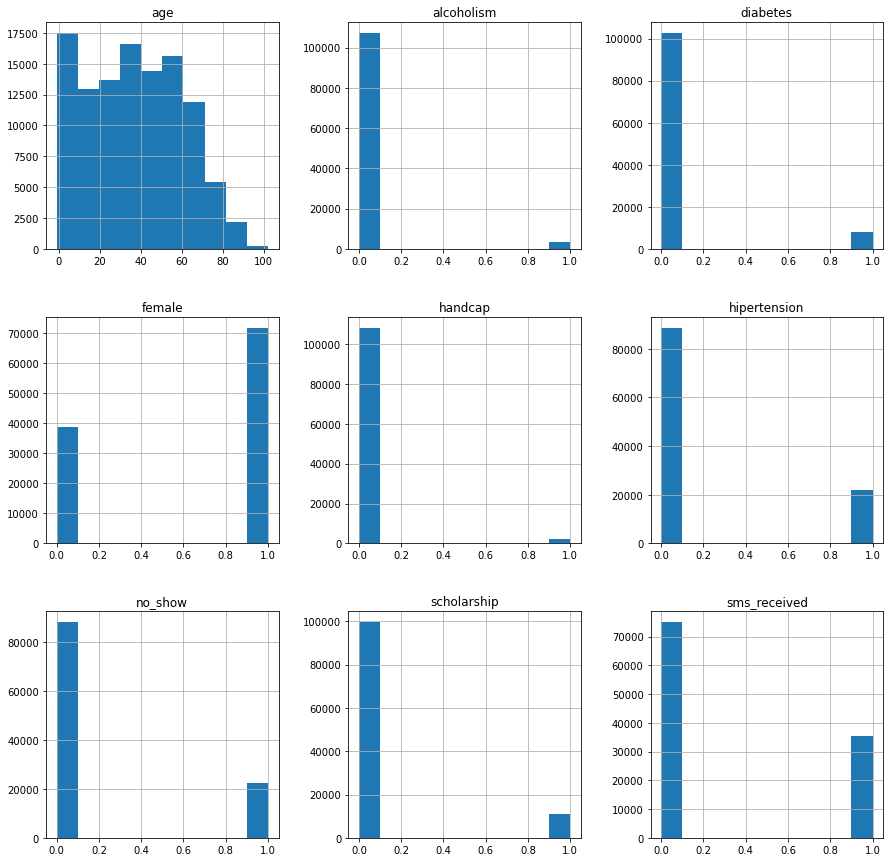

In [20]:
# get a view of the distributions of each variable

df.hist(figsize = (15,15));

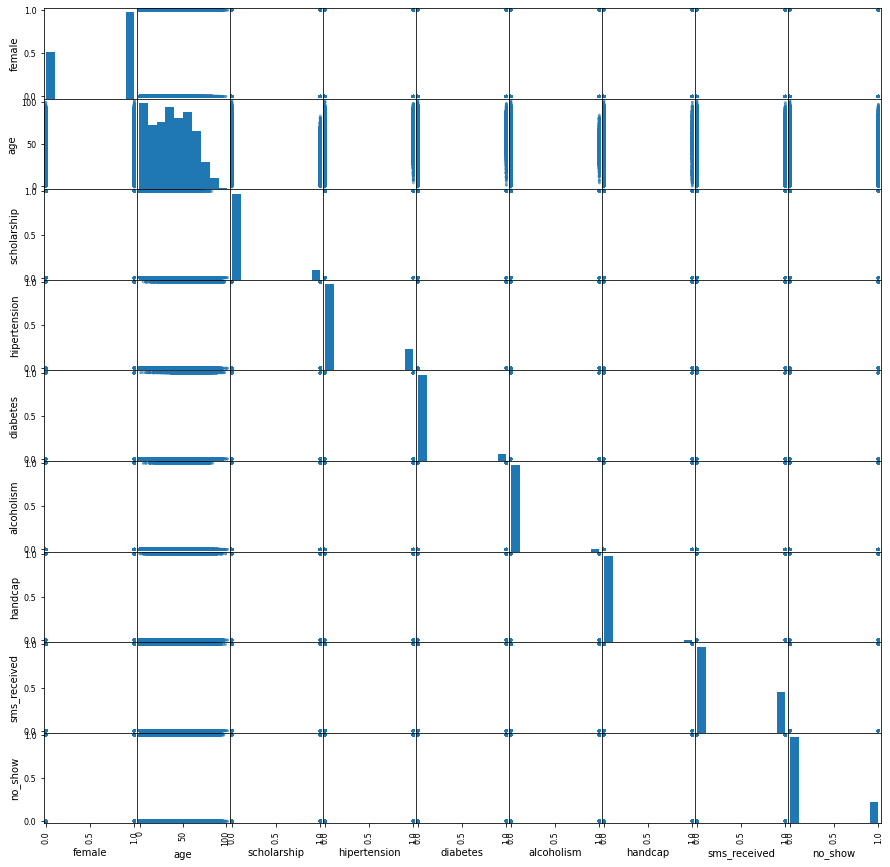

In [21]:
# let's check the correlations as well

pd.plotting.scatter_matrix(df, figsize=(15,15));

As expected the relation between the variables cannot be give by a scatter plot since all variables besides age are binary. Now let us make a deep dive into the questions.

Since `no_show` is our dependent variable, I will create a mask, that will make the further analysis much easier

In [23]:
show_mask = df.no_show == 0
no_show_mask = df.no_show == 1

### Research Question 1: Does the time between scheduling the appointment and the appointment itself have an impact in the no-show behaviour of the patients?

First we need to create a column that contains the information we are looking for: the time in days between scheduling and the appointment

In [24]:
df['time_passed'] = df['appointmentday'] - df['scheduledday'] 
df['time_passed'] = df['time_passed']
df.head(2)

,female,scheduledday,appointmentday,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show,time_passed
0,1,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,0,1,0,0,0,0,0,-1 days +05:21:52
1,0,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,0,0,0,0,0,0,0,-1 days +07:51:33


In [25]:
df['time_passed']

0        -1 days +05:21:52
1        -1 days +07:51:33
2        -1 days +07:40:56
3        -1 days +06:30:29
4        -1 days +07:52:37
                ...       
110522    34 days 14:44:25
110523    34 days 16:32:27
110524    40 days 07:56:08
110525    40 days 08:50:37
110526    40 days 10:29:04
Name: time_passed, Length: 110522, dtype: timedelta64[ns]

In [26]:
# for further calculations we need to convert the timestamps to floats
df['time_passed'] = df['time_passed'] / np.timedelta64(1, 'D')
df['time_passed']

0         -0.776481
1         -0.672535
2         -0.679907
3         -0.728831
4         -0.671794
            ...    
110522    34.614178
110523    34.689201
110524    40.330648
110525    40.368484
110526    40.436852
Name: time_passed, Length: 110522, dtype: float64

We can see that there are some neagitve values. By definition this should not be the case. Before we do something with them, we need to understand it better

In [27]:
df.query('time_passed < 0').time_passed.describe()

count    38567.000000
mean        -0.445791
std          0.130287
min         -6.575926
25%         -0.552633
50%         -0.406655
75%         -0.338571
max         -0.256667
Name: time_passed, dtype: float64

There are too many negative values! approx. 40,000 entries! Clearly there must have been some error when recording the dates. Since I have no furhter information, if this error just mean that the patient had their appoint on the same day, I will have to ignore all these entries to answer question 1.

In [28]:
# create a new dataframe without the rows with the negative entries 
df_time = df.copy()
df_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110522 entries, 0 to 110526
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   female          110522 non-null  int64              
 1   scheduledday    110522 non-null  datetime64[ns, UTC]
 2   appointmentday  110522 non-null  datetime64[ns, UTC]
 3   age             110522 non-null  int64              
 4   scholarship     110522 non-null  int64              
 5   hipertension    110522 non-null  int64              
 6   diabetes        110522 non-null  int64              
 7   alcoholism      110522 non-null  int64              
 8   handcap         110522 non-null  int64              
 9   sms_received    110522 non-null  int64              
 10  no_show         110522 non-null  int64              
 11  time_passed     110522 non-null  float64            
dtypes: datetime64[ns, UTC](2), float64(1), int64(9)
memory usage: 11.0 MB


In [29]:
# drop the rows that are not relevant anymore

df_time.drop(df_time.index[df_time.time_passed < 0], inplace=True)
df_time.time_passed.describe()

count    71955.000000
mean        15.159845
std         16.490807
min          0.136343
25%          3.635347
50%          8.684363
75%         21.625747
max        178.554873
Name: time_passed, dtype: float64

Now that we have cleaned the new variable is time to take a look at the distribution

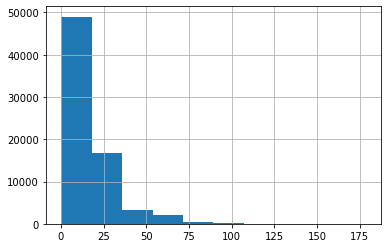

In [31]:
# let's get an idea of the distribution
df_time['time_passed'].hist(bins = 10);

I suspect the no-shows have appointments much later. For this, let us take a look of the distribution for the "no-show" and "show" regarding the amount of time until the appointment

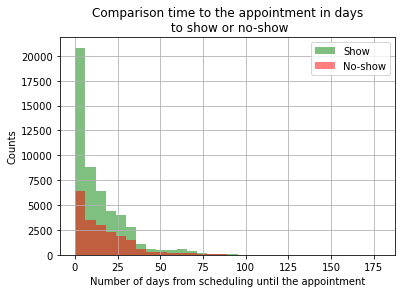

In [32]:
# create a histogram to see the distribution
df_time.time_passed[show_mask].hist(alpha = 0.5, color = 'green', bins=30, label='Show');
df_time.time_passed[no_show_mask].hist(alpha = 0.5, color = 'red', bins=30, label='No-show');
plt.legend();
plt.title('Comparison time to the appointment in days\n to show or no-show')
plt.xlabel('Number of days from scheduling until the appointment')
plt.ylabel('Counts');

The distribution already provides the first insights: it seems that no-show tend to be stronger if the appointment is between the first 30 days.
Let us take a look of the cumulative distribution function to validate this:

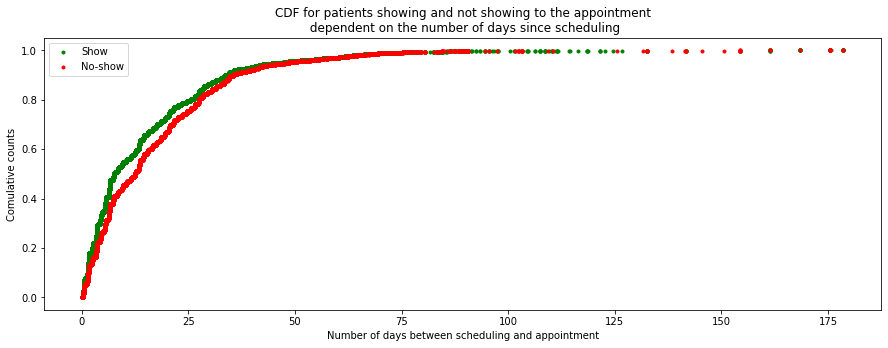

In [33]:
plt.figure(figsize=(15,5))
x_show = np.sort(df_time.time_passed[show_mask])
y_show = np.arange(1, len(x_show)+1) / len(x_show)
plt.plot(x_show, y_show, marker='.', linestyle='none', color='green', label='Show')

x_no_show = np.sort(df_time.time_passed[no_show_mask])
y_no_show = np.arange(1, len(x_no_show)+1) / len(x_no_show)
plt.plot(x_no_show, y_no_show, marker='.', linestyle='none', color='red', label='No-show')
plt.title('CDF for patients showing and not showing to the appointment\n dependent on the number of days since scheduling')
plt.xlabel('Number of days between scheduling and appointment')
plt.ylabel('Comulative counts')
plt.legend();

Great! from this perspective we can see that no-shows tend to happen more often if there is more time between the appointment and the day it was scheduled. Further statistical analysis is needed to confirm this hypothesis.

### Research Question 2: Are males more likely to miss an appointment? How does the age affect each gender in their behaviour of showing up (or not showing up) to the medical appointments? 

In [34]:
# let's take a look of the distribution between male and female

df.female.describe()

count    110522.000000
mean          0.649961
std           0.476984
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: female, dtype: float64

There are many more female in the datase than male. So we need to normalize it to avoid any biases

In [35]:
total_female = df.query('female == 1')['female'].count()
total_male = df.query('female == 0')['female'].count()
print(total_female + total_male) # check that the count is correct

110522


In [36]:
# get a dataframe with the proper counts for show and no_show
behaviour_counts = df.groupby(['female', 'no_show']).count()['age']
behaviour_counts

female  no_show
0       0          30962
        1           7725
1       0          57244
        1          14591
Name: age, dtype: int64

In [37]:
# get the female and male proportions
female_proportion = behaviour_counts[1] / total_female
male_proportion = behaviour_counts[0] / total_male
male_proportion

no_show
0    0.800321
1    0.199679
Name: age, dtype: float64

This looks great, it is time to plot these in a bar chart. First set the coordinates and the width of the bars

In [38]:
coordinates = np.arange(len(female_proportion))
width = 0.25

let's create the plot! **Be careful!** the two graphs should be next to each other, which means that they are shifted (or moved) by the "width" - take this into account when defining the *x-coordinates*

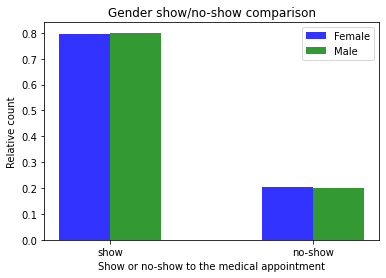

In [39]:
female_bars = plt.bar(coordinates, female_proportion, width, color='blue', alpha=0.8, label='Female')
male_bars = plt.bar(coordinates+width, male_proportion, width, color='green', alpha=0.8, label='Male')
plt.title('Gender show/no-show comparison')
plt.ylabel('Relative count')
plt.xlabel('Show or no-show to the medical appointment')
coordinates_xlabels = coordinates + width / 2
plt.xticks(coordinates_xlabels, ['show', 'no-show'])
plt.legend();

A direct comparison between females and males show almost no difference. This needs to be validated using further statistical methods. 

Now to the second part of the question. We want to know if the age makes a difference on showing up to the appointment - for females and males. There is no better way than looking at the CDF of both genders:

**Let's start with the female CDF**

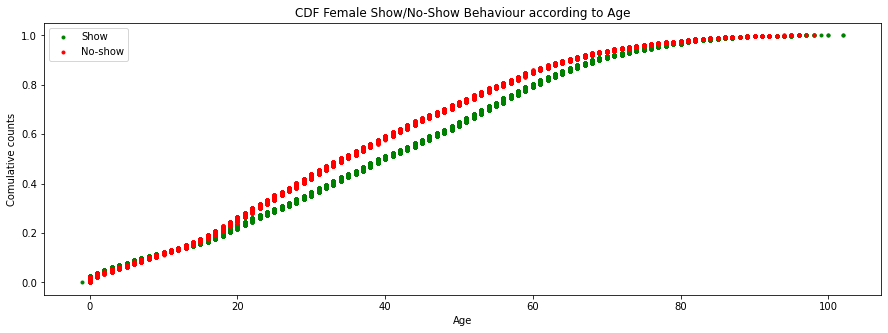

In [40]:
# female age show and not show
# let us create a dataframe with only females
df_fem = df.copy()
df_fem.drop(df_fem.index[df_fem.female == 0], inplace = True)

# plot the CDF 
plt.figure(figsize=(15,5))
x_show = np.sort(df_fem.age[show_mask])
y_show = np.arange(1, len(x_show)+1) / len(x_show)
plt.plot(x_show, y_show, marker='.', linestyle='none', color='green', label='Show')

x_no_show = np.sort(df_fem.age[no_show_mask])
y_no_show = np.arange(1, len(x_no_show)+1) / len(x_no_show)
plt.plot(x_no_show, y_no_show, marker='.', linestyle='none', color='red', label='No-show')
plt.title('CDF Female Show/No-Show Behaviour according to Age')
plt.xlabel('Age')
plt.ylabel('Comulative counts')
plt.legend();

**Let's take a look to the male CDF**

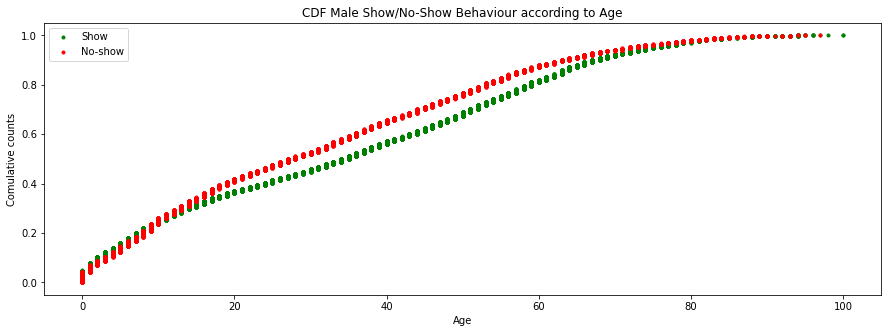

In [41]:
# male age show and not show
# let us create a dataframe with only females
df_male = df.copy()
df_male.drop(df_male.index[df_male.female == 1], inplace = True)

# plot the CDF 
plt.figure(figsize=(15,5))
x_show = np.sort(df_male.age[show_mask])
y_show = np.arange(1, len(x_show)+1) / len(x_show)
plt.plot(x_show, y_show, marker='.', linestyle='none', color='green', label='Show')

x_no_show = np.sort(df_male.age[no_show_mask])
y_no_show = np.arange(1, len(x_no_show)+1) / len(x_no_show)
plt.plot(x_no_show, y_no_show, marker='.', linestyle='none', color='red', label='No-show')
plt.title('CDF Male Show/No-Show Behaviour according to Age')
plt.xlabel('Age')
plt.ylabel('Comulative counts')
plt.legend();

The pattern for both genders is very similar. In both cases older people tend to show up more to the medical appointment. Furhter statistical analysis is neede to validate the hypothesis. 

<a id='conclusions'></a>
## Conclusions

There are way mor things that we could lern about the data. However, in this report we concentrate on two main questions: 

* **Question 1:** Does the time between scheduling the appointment and the appointment itself have an impact in the no-show behaviour of the patients?
>**Conclusion:** from the first analysis of the data we conclude that the longer a patient has to wait for her/his appointment the more likely it is that she/he misses it. However, we did not run any statistical test to corroborate this. Further analysis is necessary.

* **Question 2:** Are males more likely to miss an appointment? How does the age affect each gender in their behaviour of showing up (or not showing up) to the medical appointments? 
>**Conclusion:** according to our analysis there seems to be no difference between female and male when it comes to showing up to the appointment. Both genders are equally likely to miss it. However, as before further statistical analysis is necessary to validate this. 
>
>On the other hand, the age seems to have an impact in both genders when it comes to their no-show behaviour. Younger patients seem to be more likely to miss their appointments. However, this also needs further statistical analysis and proper tests. 

Further exciting questions remain open for future research!
